## Git configuration (probably no needs)

In [6]:
!git --version

git version 2.25.1


In [7]:
!git config --global user.email "rpoj18.1.denya.lobanov1@gmail.com"
!git config --global user.name "DenyaOmega3"

In [8]:
!git clone https://github.com/DenyaOmega3/Pics_To_TIKZ.git

Cloning into 'Pics_To_TIKZ'...


In [ ]:
%cd TikZ_Code_Generator
!pwd

/content/TikZ_Code_Generator
/content/TikZ_Code_Generator


## Pixel <-> cm converter

In [ ]:
pixel_multiplier = 37.7952755906

def convert_cm_length_into_pixel(size):
  return size*pixel_multiplier

def convert_pixel_length_into_cm(size):
  return size/pixel_multiplier

## Px <-> Pt converter

In [ ]:
pt_multiplier = 3/4.0

def convert_px_into_pt(px_value):
  return px_value*pt_multiplier

## Line Detector

[[[ 96 208 316 145]]

 [[108 210 245 173]]]


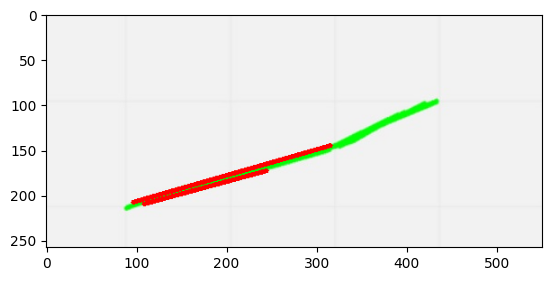

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("Line3(rec1).jpg")
color_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 130, 230)

lines = cv2.HoughLinesP(edges, 1, np.pi/180, 1, minLineLength = 100, maxLineGap = 20)

print(lines)
for line in lines:
  x1, y1, x2, y2 = line[0]
  cv2.line(color_img, (x1,y1), (x2,y2), (255,0,0), 3)

plt.imshow(color_img)
#plt.imshow(edges)
plt.show()

Hough transform usually generates almost the same points, thus generates almost the same line equation.

## Defining a color

So we found a straight line, now we should specify line's color. It should be defined by going through all points that lies in the line and seeing its color distribution. Take its mean value

In [ ]:
def line_equation_at(x):
  x_1,y_1,x_2,y_2 = 724, 276, 1008, 296
  return y_1 + (y_2-y_1)/(x_2-x_1)*(x-x_1)

x_start = 724
x_end = 1008
pixels = []
avg_r,avg_g,avg_b = 0,0,0

for x in range(x_start,x_end):
  y = int(line_equation_at(x))
  avg_r += color_img[y][x][0]
  avg_g += color_img[y][x][1]
  avg_b += color_img[y][x][2]

amount = x_end - x_start
avg_r /= amount
avg_g /= amount
avg_b /= amount
print(int(avg_r),int(avg_g),int(avg_b))

101 119 145


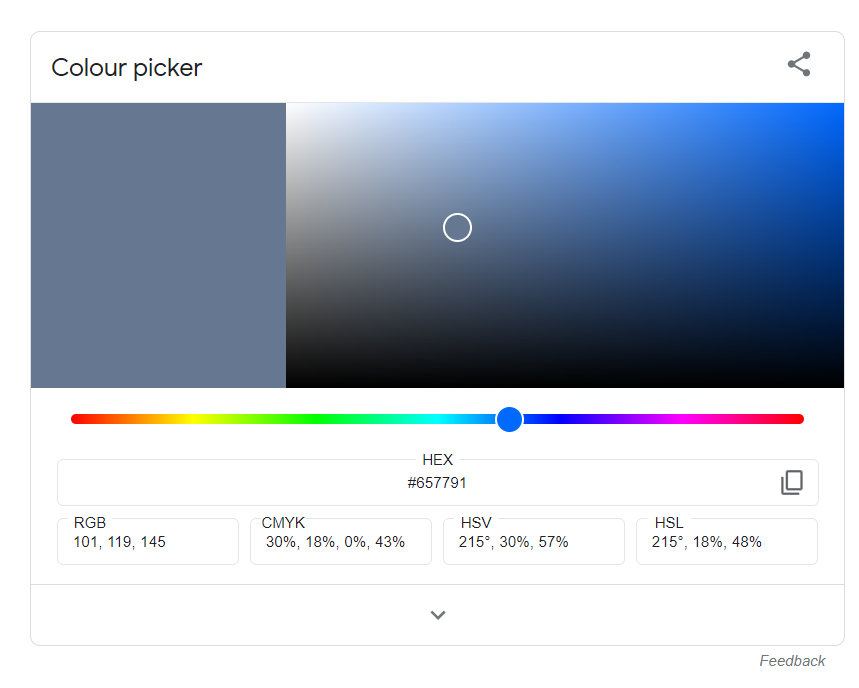

## Convert into TikZ

Expecting to have: /draw(x_start, y_start) -- (x_end, y_end)

In [ ]:
def line_in_TikZ_code(points):
  draw_line_command = '\draw '

  for pos in range(0,len(points)):
    x, y = points[pos][0], points[pos][1]
    if draw_line_command.find('({},{})'.format(x, y)) != -1:
      draw_line_command += 'cycle'
    else:
      draw_line_command += '({},{})'.format(x, y)
    if pos+1 < len(points):
      draw_line_command += ' -- '

  return draw_line_command

In [ ]:
points = [[lines[0][0][0],lines[0][0][1]],[lines[0][0][2],lines[0][0][3]]]
points
line_in_TikZ_code(points)

another_points = [[0,0], [1,1], [2,0], [0,0], [0,1]]
line_in_TikZ_code(another_points)

'\\draw (0,0) -- (1,1) -- (2,0) -- cycle -- (0,1)'

## Attempt to build a CNN
Basic strategy to build a CNN for our case:
- get some dataset of straight lines which might be not exactly straight but pretty close to it;
- scale dataset up to size $128 \times 128$;
- create labels for each picture that represent coordinates of starting and ending points

## Connection to Google Drive
There's a folder "Line" where I store my unprocessed dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## For constructing CNN

In [2]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
import numpy as np

## For accessing to folders

In [3]:
import os

In [3]:
image_extensions = ['jpg', 'png', 'jpeg']

In [4]:
data_directory = 'drive/MyDrive/Line'

In [ ]:
for image_class in os.listdir(data_directory):
  for image in os.listdir(os.path.join(data_directory, image_class)):
    print(image)

#just traversing through all filenames

## Scaling procedure
Just in order to create a dataset and send it to CNN, it requires to have images of the same size. I consider to scale up to (256,256)

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

images_almost_straight = []
images_rough = []
images_straight = []

for image_class in os.listdir(data_directory):
  for image in os.listdir(os.path.join(data_directory, image_class)):
    img = cv2.imread(os.path.join(data_directory, image_class, image))
    color_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(color_img, (128,128), interpolation = cv2.INTER_AREA)
    if image_class == 'Straight line':
      images_straight.append(resized)
    elif image_class == 'Almost straight line':
      images_almost_straight.append(resized)
    elif image_class == 'Rough line':
      images_rough.append(resized)

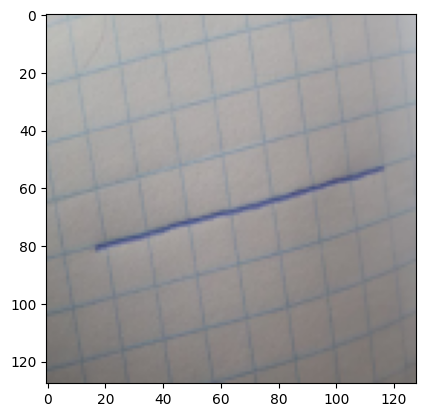

In [96]:
plt.imshow(images_almost_straight[22])
plt.show()

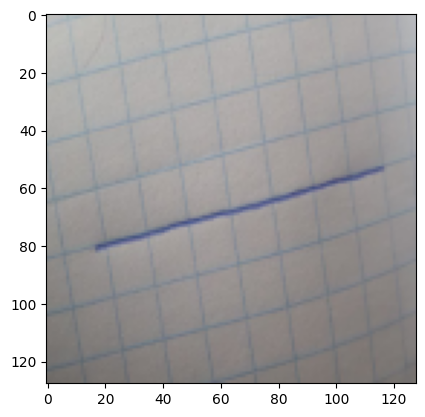

In [37]:
resized = cv2.resize(images_almost_straight[22], (128,128), interpolation = cv2.INTER_AREA)
plt.imshow(resized)
plt.show()

An attempt to apply Hough Transform to find end points.

Remind for myself, what are parameters:
- image with detected contours (mostly Canny)
- rho
- theta
- threshold

The rest is understood

In [ ]:
picture_id = 1
img = images_almost_straight[picture_id]
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 130, 230)

lines = cv2.HoughLinesP(edges, 1, np.pi/180, 1, minLineLength = 40, maxLineGap = 20)

print(lines)
for line in lines:
  x1, y1, x2, y2 = line[0]
  cv2.line(img, (x1,y1), (x2,y2), (255,0,0), 2)

plt.imshow(img)
plt.show()

## Downloading processed images

In [93]:
directory = 'scaled_straight_img_2'
os.chdir("../")

#for i in range (0,len(images_straight)):
  #cv2.imwrite(str(i)+".jpg", images_straight[i])

In [ ]:
!zip -r /content/scaled_img.zip /content/scaled_straight_img_2

In [90]:
from google.colab import files
files.download("/content/scaled_img.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Each image maps to array of 4 integers representing coordinates that gives me a line.

Problem: to know coordinates it must be checked **manually**.

Claim: find an approach to specify those coordinates using some algorithm

In [11]:
y_label_almost_straight = np.array([
    [51,180,195,68],
    [26,227,137,30],
    [78,47,146,128],
    [45,60,188,183],
    [98,163,176,72],
    [43,116,175,122],
    [96,170,187,46],
    [120,227,117,49],
    [118,192,156,51],
    [122,229,113,27],
    [129,206,107,41],
    [0,210,180,12],
    [40,82,236,156],
    [39,213,155,13],
    [12,163,220,23],
    [60,53,127,216],
    [104,9,119,166],
    [115,18,120,175],
    [46,21,180,237],
    [85,120,241,103],
    [0,149,255,44],
    [87,132,218,124],
    [34,163,233,108],
    [0,255,191,79],
    [93,43,93,147],
    [109,38,118,145],
    [79,45,83,160],
    [75,219,198,86],
    [47,38,247,138],
    [219,105,47,105],
    [147,233,124,45],
    [33,229,175,47],
    [195,15,195,155],
    [51,31,213,181],
    [205,121,65,111],
    [86,21,209,253],
    [27,113,173,26],
    [28,141,182,105],
    [30,123,162,95],
    [30,175,227,128],
    [24,156,202,144],
    [198,96,28,191],
    [213,72,21,186],
    [8,178,157,53],
    [106,150,171,225],
    [66,205,212,99],
    [30,241,199,123],
    [14,45,219,182],
    [15,174,219,182],
    [65,41,175,234],
    [54,151,194,59],
    [31,71,222,159],
    [18,27,180,148],
    [91,181,152,64],
    [63,36,137,211],
    [93,31,128,202],
    [21,57,197,197],
    [46,157,160,127],
    [50,115,162,115],
    [48,106,254,116],
    [230,233,16,50],
    [0,30,214,233],
    [40,58,115,222],
    [52,219,135,30],
    [84,251,238,124],
    [10,214,232,6],
    [69,223,133,33],
    [18,229,136,77],
    [33,81,222,170],
    [7,26,228,253],
    [76,25,253,200],
    [117,11,167,190],
    [153,22,104,237],
    [0,211,139,0],
    [80,182,190,59],
    [226,120,14,115]
])
#total (0)-(75) images (almost straight). I wrote coordinates for 256x256 images.
#to get coordinates for 128x128 this array we'll divide by 2 due to linearity.

In [ ]:
y_label_almost_straight

There's an idea how to artificially double dataset. Since each output represents coordinates of starting and ending point, we'll swap these coordinates.

Say we have [0,211,139,0] - starting point (0,211) and ending point (139,0). We'll construct another output [139,0,0,211] - starting point (139,0) and ending point (0,211). Both outputs represent the same line => the same image.

In [16]:
y_label_almost_straight_flipped = []
for line in y_label_almost_straight:
  new_line = [line[2],line[3],line[0],line[1]]
  y_label_almost_straight_flipped.append(new_line)

y_label_almost_straight_flipped = np.array(y_label_almost_straight_flipped)

In [ ]:
y_label_almost_straight_flipped

In [18]:
y_label_straight = np.array([
    [17,61,189,194],
    [71,26,167,222],
    [48,140,240,140],
    [31,165,201,128],
    [37,79,207,156],
    [27,111,212,161],
    [161,208,161,32],
    [30,181,233,78],
    [35,145,230,136],
    [38,138,213,48],
    [41,43,209,180],
    [41,151,187,94],
    [26,122,188,129],
    [70,200,212,64],
    [40,35,192,172],
    [29,74,231,74],
    [37,51,159,180],
    [7,35,213,60],
    [56,232,108,36],
    [21,48,248,138],
    [79,219,120,49],
    [61,107,255,61],
    [61,107,255,61],
    [62,0,191,255],
    [55,255,182,54],
    [7,56,232,152],
    [173,41,173,226],
    [50,16,193,228],
    [16,64,216,162],
    [134,0,84,255],
    [12,133,199,126],
    [20,41,213,220],
    [60,46,189,221],
    [29,173,255,77],
    [24,98,242,112],
    [89,14,120,248],
    [0,0,247,247],
    [23,119,212,139],
    [23,190,212,111],
    [76,27,161,239],
    [90,28,79,202],
    [77,164,201,106],
    [29,108,212,121],
    [48,71,216,144],
    [49,31,141,201],
    [65,112,179,191],
    [21,114,188,122],
    [27,77,234,201],
    [46,24,191,188],
    [127,0,121,206],
    [18,193,204,102],
    [87,226,230,120],
    [145,18,70,176],
    [25,92,210,145],
    [85,200,227,149],
    [71,201,197,38],
    [27,111,200,119],
    [32,29,150,222]
    ])

# now (0)-(57) images (straight) for pictures 256x256

In [19]:
y_label_straight_flipped = []
for line in y_label_straight:
  new_line = [line[2],line[3],line[0],line[1]]
  y_label_straight_flipped.append(new_line)

y_label_straight_flipped = np.array(y_label_straight_flipped)

In [ ]:
y_label_straight_flipped

In [54]:
arr1 = np.array(images_almost_straight, copy=True)
arr2 = np.array(images_almost_straight, copy=True)
arr3 = np.array(images_straight, copy=True)
arr4 = np.array(images_straight, copy=True)

brr1 = np.array(y_label_almost_straight, copy=True)
brr2 = np.array(y_label_almost_straight, copy=True)
brr3 = np.array(y_label_straight, copy=True)
brr4 = np.array(y_label_straight, copy=True)

X_label = np.concatenate((arr1,arr3))
y_label = np.concatenate((brr1/2,brr3/2))

X_label.shape

(134, 128, 128, 3)

In [55]:
from sklearn.utils import shuffle
X_label, y_label = shuffle(X_label, y_label)

Quick reminder for myself:
- Conv2D(filters, kernel, activation, padding, input_shape)

In [49]:
import numpy as np

training_portion = int(len(X_label)*0.8)

X_train = X_label[0:training_portion]
y_train = y_label[0:training_portion]
X_validation = X_label[training_portion:]
y_validation = y_label[training_portion:]

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(256,256,3)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(16, (3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(8, (3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4)
])

#case 256x256

In [56]:
import numpy as np

training_portion = int(len(X_label)*0.8)

X_train = X_label[0:training_portion]
y_train = y_label[0:training_portion]
X_validation = X_label[training_portion:]
y_validation = y_label[training_portion:]

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128,128,3)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(16, (3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(16, (3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4)
])

#case 128x128

In [57]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(),loss=tf.keras.losses.MeanAbsoluteError(),metrics=['accuracy'])

In [ ]:
model.summary()

In [58]:
history = model.fit(X_train, y_train, validation_data = (X_validation,y_validation), epochs=20)

Epoch 1/20
4/4 [==============================] - 2s 72ms/step - loss: 59.5347 - accuracy: 0.5234 - val_loss: 48.9741 - val_accuracy: 0.4074
Epoch 2/20
4/4 [==============================] - 0s 21ms/step - loss: 35.8914 - accuracy: 0.5421 - val_loss: 28.9573 - val_accuracy: 0.4074
Epoch 3/20
4/4 [==============================] - 0s 21ms/step - loss: 27.7617 - accuracy: 0.5421 - val_loss: 34.8691 - val_accuracy: 0.4074
Epoch 4/20
4/4 [==============================] - 0s 21ms/step - loss: 29.4550 - accuracy: 0.5421 - val_loss: 30.4724 - val_accuracy: 0.4074
Epoch 5/20
4/4 [==============================] - 0s 23ms/step - loss: 27.5399 - accuracy: 0.5421 - val_loss: 30.6124 - val_accuracy: 0.4074
Epoch 6/20
4/4 [==============================] - 0s 22ms/step - loss: 27.6086 - accuracy: 0.5421 - val_loss: 31.6701 - val_accuracy: 0.4074
Epoch 7/20
4/4 [==============================] - 0s 24ms/step - loss: 26.9722 - accuracy: 0.5421 - val_loss: 29.1890 - val_accuracy: 0.4074
Epoch 8/20
4/

In [71]:
predict_img = cv2.imread('predict_line.jpg')
color_predict_img = cv2.cvtColor(predict_img, cv2.COLOR_BGR2RGB)
resized_predict = cv2.resize(color_predict_img, (128,128), interpolation = cv2.INTER_AREA)

In [72]:
y_scaled_predict = model.predict(np.expand_dims(resized_predict,0))
y_scaled_predict
#partially failed

1/1 [==============================] - 0s 18ms/step


array([[ 23.562893,   9.567674,  97.01097 , 104.694916]], dtype=float32)

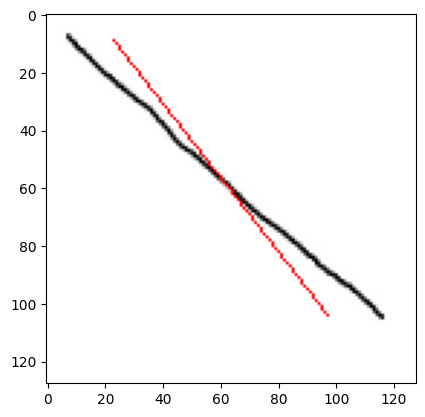

In [73]:
cv2.line(resized_predict, (int(y_scaled_predict[0][0]),int(y_scaled_predict[0][1])), (int(y_scaled_predict[0][2]),int(y_scaled_predict[0][3])), (255,0,0), 1)
plt.imshow(resized_predict)
plt.show()